In [61]:
import numpy as np
import ToyQ2
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Data/UH_RL_rats.csv');
df = df.drop(df.columns[[range(24)]],axis=1);
from scipy.optimize import minimize

# Packaging into respective subjects

In [57]:
subjects = df['subject'].unique();
sub_df={} # a dictionary whose keys is the subject number
for i in subjects:
    sub_df[i]=df[df['subject']==i]
df = pd.read_csv('Data/UH_RL_rats.csv');
day1 = pd.read_csv('Data/Day 1.csvQ_Analysis.csv');
day21 = pd.read_csv('Data/Day 21.csvQ_Analysis.csv');
excel=pd.read_excel('Data/UH2 Probabilistic Reversal Learning EEG.xlsx')
def get_behavior(day_df,rat_num):
    return day_df[day_df['subject']==rat_num]

def log_from_behavior(behavior,reward_tone):
    actions=np.full(behavior['target_lat'].shape,2)
    idx=behavior['target_lat']!=0
    actions[idx]=1
    
    tone=behavior['Tone']
    lowtone=min(set(tone))
    hitone=max(set(tone))
    flg='High' in reward_tone
    rewards=np.ones(behavior['Tone'].shape)
    rewards[tone==lowtone]=1-int(flg)
    rewards[tone==hitone]=int(flg)
    return actions,rewards

def get_Logs(sub_df):
    '''Returns a dict of DataFrame indexs as dict[rat number][session name]
    where rat is int from 1 to 24 and session name is 1, 11, 16,6, Best as strings'''
    Logs={}
    for i in sub_df:
        rat=sub_df[i]
        sessions=rat['session'].unique()
        Logs[i]={}
        for j,sesh in enumerate(sessions):
            Logs[i][sesh]={}
            Logs[i][sesh]=rat[rat['session']==sesh]
    return Logs
epoched_df=get_Logs(sub_df)

In [137]:
class RL_env():
    def __init__(self,actions,rewards):
        '''takes in the data of a rat over one single trial'''
        self.reward=np.array(rewards)
        self.count=0 # counting from 0
    def step(self,action):
        temp=self.reward[self.count]+0
        self.count+=1
        return temp
    def init_Q(self):
        left=self.epoched_df[self.epoched_df['action']==1]['Q'].iloc[0]
        right=self.epoched_df[self.epoched_df['action']==2]['Q'].iloc[0]
        return np.array([right,left])

class Rat():
    def __init__(self,actions,alphaG=None,alphaL=None,beta=None,gamma=0,init_Q=np.array([-1,-1]),sim=True):
        self.gamma=gamma
        self.count=0
        self.beta=beta
        self.PElog=[] # prediction error (Q-R)
        self.PElog.append(0)
        self.choice_Log=[]
        self.obsLog=[]
        self.lhLog=[]
        if sim==False:
            self.actions=np.array(actions)
        else:
            self.actions=[]
        self.alphaG=alphaG
        self.alphaL=alphaL
        self.beta=beta
        if (init_Q==np.array([-1,-1])).all():
            self.Q=np.random.rand(2) # Q[0] represent left
        else:
            self.Q=init_Q
        self.Qlog=self.Q
        self.qlog=[0]
    def get_action(self):
        temp=self.count+0
        self.count+=1
        self.choice_Log.append(self.actions[temp])
        return self.actions[temp]
    def get_choice(self):
        self.count+=1
        if np.random.uniform()<1/(1+np.exp(-self.beta*(self.Q[0]-self.Q[1]))):
            self.choice_Log.append(1)
            return 1
        else:
            self.choice_Log.append(2)
            return 2
    def update(self,obs): # 1 represent left 
        action_id=int(self.choice_Log[-1]-1)
        self.obsLog.append(obs)
        self.PElog.append(self.Q[action_id]-obs)
        if int(obs)==1: # alpha_gain
            self.Q[action_id]=(1-self.alphaG)*self.Q[action_id]+self.alphaG*(obs+self.gamma*np.max(self.Q))
        elif int(obs)==0: # alpha_loss
            self.Q[action_id]=(1-self.alphaL)*self.Q[action_id]+self.alphaL*(obs+self.gamma*np.max(self.Q))
        else:
            print('error')
        self.lhLog.append(1/(1+np.exp(-self.beta*self.Q[action_id])))
        self.Qlog=np.vstack((self.Qlog,self.Q))
        self.qlog.append(self.Q[action_id])
        return self.Q[action_id]
    
    
def train_rat(env,rat,it_num,sim=True):
    QLog=rat.Q
    qlog=[0]
    for i in range(it_num):
        if sim:
            action=rat.get_choice()
        else:
            action=rat.get_action()
        obs=env.step(action)
        q=rat.update(obs)
        QLog=np.vstack((QLog,rat.Q))
        qlog.append(q)
    return env,rat

# Real_data Demo

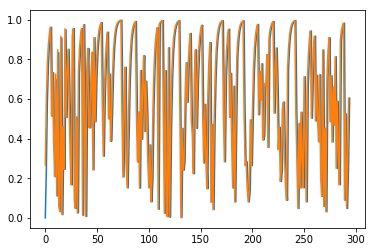

In [116]:
mydf=epoched_df[12]['Best']
env=RL_env(mydf['action'],mydf['reward']) 
rat=Rat(mydf['action'],0.450942,0.466634,	0.553753,init_Q=np.array([0.45,0.45]),sim=False)
env,rat=train_rat(env,rat,mydf.shape[0],sim=False)
plt.plot(rat.qlog)
plt.plot(range(len(mydf)),mydf['Q'])

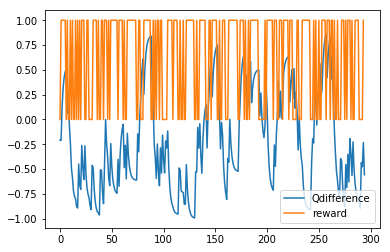

In [128]:
plt.plot(rat.Qlog[:,0]-rat.Qlog[:,1])
plt.plot(range(len(rat.qlog)-1),mydf['reward'])
plt.legend(('Qdifference','reward'))

# Butterfly

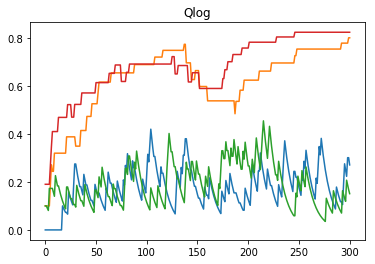

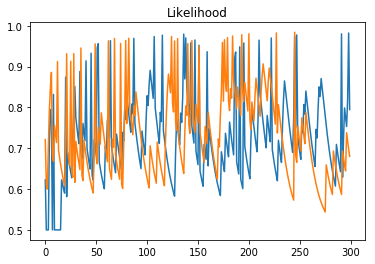

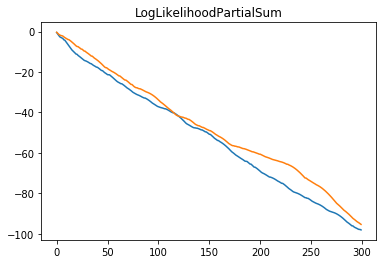

In [136]:
from functools import reduce
env=ToyQ2.toyQ_2choice()
rat1=Rat(None,alphaG=0.1,alphaL=0.1,beta=5,init_Q=np.array([0.000001,0.00001]),sim=True)
env,rat1=train_rat(env,rat1,300,sim=True)
plt.plot(rat1.Qlog)
env=ToyQ2.toyQ_2choice()
rat2=Rat(None,0.1,0.1,5,init_Q=np.array([0.1,0.1]),sim=True)
env,rat2=train_rat(env,rat2,300,sim=True)
plt.plot(rat2.Qlog)
plt.title('Qlog')
plt.figure(2)
plt.title('Likelihood')
plt.plot(rat1.lhLog)
plt.plot(rat2.lhLog)
plt.figure(3)
plt.title('LogLikelihoodPartialSum')
rat1log=np.log(rat1.lhLog)
rat2log=np.log(rat2.lhLog)
rat1ps=reduce(lambda c, x: c + [c[-1] + x], rat1log, [0])[1:]
rat2ps=reduce(lambda c, x: c + [c[-1] + x], rat2log, [0])[1:]
plt.plot(rat1ps)
plt.plot(rat2ps)

# Visualization

# PE is R-Q

# I/O